# Attempt to Model Velocity Dependence
Using the multiple runs from the Si dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport stopping_power_ml
from matplotlib import pyplot as plt
from stopping_power_ml.io import get_charge_density_interpolator, load_directory
from stopping_power_ml.features import LocalChargeDensity, IonIonForce, ProjectedAGNIFingerprints
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from glob import glob
from tqdm import tqdm_notebook as tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import os

## Load in Data
Read in data from all velocities

Load in all directories

In [2]:
files = glob('256_Al/D**/kpgen*.out')
dirs = set([os.path.dirname(x) for x in files])
print('Found %d files in %d directories'%(len(files), len(dirs)))

Found 11 files in 5 directories


In [3]:
data = [load_directory(d, prefix='kpgen', verbose=True) for d in tqdm(dirs, desc='Directories')]

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
data = pd.concat(data)

How much data from each type?

In [5]:
for gid, group in data.groupby('directory'):
    print(gid, len(group))

256_Al/Dv0.5 24000
256_Al/Dv1.0 9800
256_Al/Dv2.0 8000
256_Al/Dv3.0 2269
256_Al/Dv4.0 4000


## Determine the "start" value
Determine the point at which the effect of adding the particle has gone away

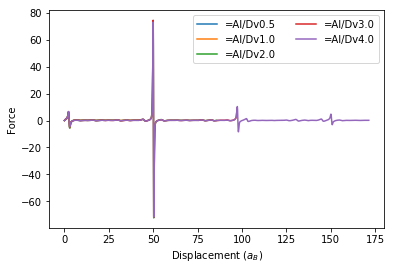

In [6]:
fig, ax = plt.subplots()

plot_max = 3000
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)
    
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

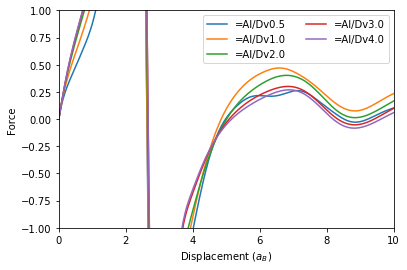

In [7]:
fig, ax = plt.subplots()

plot_max = -1
for gid, group in data.groupby('directory'):
    ax.plot(group['displacement'].iloc[:plot_max], group['force'].iloc[:plot_max], label=gid[3:].replace("_","="))

ax.legend(ncol=2)

ax.set_xlim(0, 10)

ax.set_ylim(-1, 1)
ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force')

Andre uses 6 $a_B$

In [8]:
data.query('displacement >= 6', inplace=True)

## Load in the Charge Density
Get the ground state charge density without the particle. Plot it to make sure it looks correct

In [9]:
charge, cell = get_charge_density_interpolator(os.path.join('256_Al', 'Al_semi_core_gs.cube'))

Plot the charge density along the [1,1,0] direction. Should be 8 bumps (one is split)

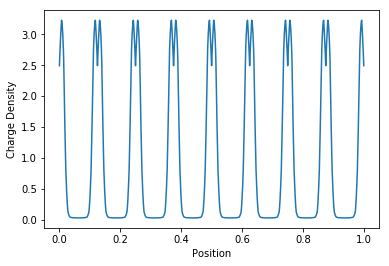

In [10]:
fig, ax = plt.subplots()

x = np.array(list(zip(np.linspace(0,1,1001), np.linspace(0,1,1001), [0,]*1001)))

ax.plot(x[:,0], charge(x))

ax.set_xlabel('Position')
ax.set_ylabel('Charge Density')

## Generate Features
Use the same features at the Al model

In [11]:
featurizers = [
    LocalChargeDensity(charge, np.linspace(1, -5, 7)),
    ProjectedAGNIFingerprints(etas=np.logspace(np.log10(0.8), np.log10(16), 8)),
    IonIonForce(acc=2)
]

In [12]:
%%time
for f in featurizers:
    data = f.featurize_dataframe(data, 'atoms', n_jobs=None)

CPU times: user 22.4 s, sys: 7.12 s, total: 29.5 s
Wall time: 58min 41s


In [13]:
X_cols = sum([f.feature_labels() for f in featurizers], [])
y_col = 'force'

## Fit on Entire Dataset
Use the Bayesian Ridge Regression model from previous examples. 

In [14]:
model = pkl.load(open('best_model.pkl', 'rb'))

In [15]:
model.steps[0][1].degree = 3

In [16]:
def fit_on_whole_dataset(model):

    model.fit(data[X_cols], data[y_col])
    data['force_fit'] = model.predict(data[X_cols])

    fig, ax = plt.subplots(1, 2)

    velocity = []
    stopping_pred = []
    stopping_actual = []
    for gid, group in data.groupby('directory'):
        velocity.append(float(gid[-3:]))
        
        # Plot the performance
        my_line, = ax[0].plot(group['displacement'], group['force'], linestyle='--', label='v='+gid[-3:])

        ax[0].plot(group['displacement'], model.predict(group[X_cols]), color=my_line.get_color(), lw=5, alpha=0.3)
        
        ax[0].set_xlim(30, 40)
        ax[0].set_ylim(-0.3, 0.7)
        ax[0].legend(ncol=2)

        ax[0].set_xlabel('Displacement (a.u.)')
        ax[0].set_ylabel('Force ($E_H / a_B$)')
        
        # Plot the mean velocity
        stopping_pred.append(group['force_fit'].mean())
        stopping_actual.append(group['force'].mean())
        
    # Plot the stopping power
    ax[1].scatter(velocity, stopping_actual, marker='o', s=80, facecolor='none', edgecolor='k', label='TD-DFT')
    ax[1].scatter(velocity, stopping_pred, marker='o', facecolor='crimson', edgecolor='k', label='ML')
    
    ax[1].set_ylabel('Stopping Power ($E_H / a_B$)')
    ax[1].set_xlabel('Velocity (au.)')
    ax[1].set_ylim(0, max(ax[1].get_ylim()))
    ax[1].set_xlim(0, 4.2)
    ax[1].legend()
    
    fig.tight_layout()
    
    return fig, ax

(<matplotlib.figure.Figure at 0x7f0340e5ddd8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f033068a438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0340466898>], dtype=object))

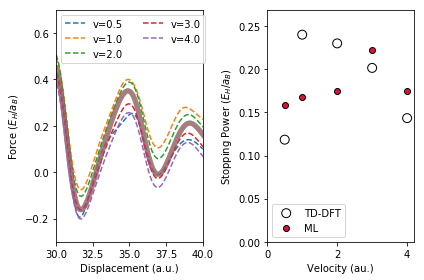

In [17]:
fit_on_whole_dataset(model)

You'll note the model predictions (thick, translucent lines) do not really differ based on velocity, and nor do the predicted stopping powers

## Add Velocity as a Variable
Can we fit the data if we add exponentials of velocity as inputs. These exponentials should have the correct limiting behavior

In [18]:
data['velocity_mag'] = data['velocity'].apply(np.linalg.norm)

In [19]:
X_cols += ['velocity_mag',]

In [20]:
for i in range(-2, 2):
    if i != 0:
        a = 'velocity_mag_exp=%i'%i
        data[a] = np.exp(i * data['velocity_mag'])
        X_cols += [a,]

/home/wardlt/software/scikit-learn/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.180e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/wardlt/software/scikit-learn/sklearn/linear_model/least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.041e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/wardlt/software/scikit-learn/sklearn/linear_model/least_angle.py:339: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 16 iterations, alpha=1.041e-04, previous alpha=1.018e-04, with an active 

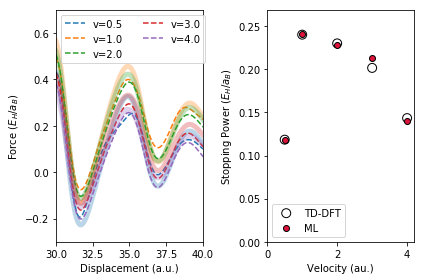

In [21]:
fig, ax = fit_on_whole_dataset(model)

fig.savefig('figures/Al_all_velocities.png', dpi=320)
fig.savefig('figures/Al_all_velocities.pdf')

The predictions do at least change significantly with the velocity, but not very well

(<matplotlib.figure.Figure at 0x7f03403c7208>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f033ff9fcf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f034039f780>], dtype=object))

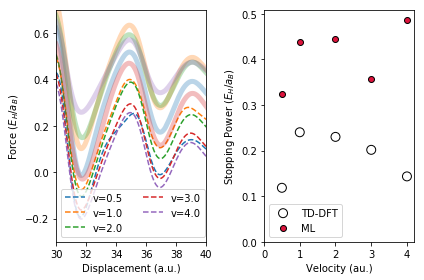

In [22]:
fit_on_whole_dataset(MLPRegressor(activation='tanh', hidden_layer_sizes=(128,64,32,16)))

With a somewhat complex NN model, we can at least fit the data

In [23]:
data[['directory',] + X_cols + [y_col,]].to_csv('Al_all_velocities.csv', index=False)